# CS 412 Intro to Data Mining

## Predicting & Pattern mining Survival on the Titanic 

# Extra Info


- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

# 1. Question or problem definition.

## Goal:
use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.


# 2. Acquire training and testing data.

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('../final project/train.csv')
test_df = pd.read_csv('../final project/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Which features contain blank, null or empty values?

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

## Stats Analysis

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# What is the distribution of categorical features?

In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


# 3. Wrangle, prepare, cleanse the data.

In [8]:
# Reference: https://www.kaggle.com/arootda/the-basic-process-of-classification-for-beginners


mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

light_palette = np.array(raw_light_palette)/255


def show_missing(data):
    light_palette = np.array(raw_light_palette)/255
    f, ax = plt.subplots(1, 1, figsize=(7, 5))
    missing_count_by_feature = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=False)
    missing_percent_by_feature = missing_count_by_feature / data.shape[0] * 100
    ax.bar(missing_percent_by_feature.index, 100, color='#dadada', width=.5)
    bar=ax.bar(missing_percent_by_feature.index, missing_percent_by_feature.values, width=.5, color='red')
    ax.bar_label(bar, fmt='%.01f %%')
    ax.spines.left.set_visible(False)
    ax.set_yticks([])
    ax.set_title('Null Data Ratio', fontweight='bold')
    plt.show()
    return pd.DataFrame([missing_count_by_feature, missing_percent_by_feature], index=['count', 'percent']).T

def piechart(data, std_name, xsize=12, ysize=5, sub_name=''):
    total_count = data.sum()
    item_size = len(data)
    if sub_name:
            sub_name = 'of ' + sub_name
    f, ax =plt.subplots(1, item_size, figsize=(xsize, ysize), facecolor='whitesmoke')
    for i, (item, count)  in enumerate(data.items()):
        colors = ['white'] * item_size
        colors[i] = 'crimson'
        ax[i].pie(data, colors=colors)
        ax[i].set_title(item, fontweight='bold', size=15)
        ax[i].set_xlabel(f'{count / total_count * 100:.2f}%',
                        fontweight='bold', size=13)
    f.suptitle(f'Percentage {sub_name} by {std_name}',
              fontweight='bold', size=20,
              color='crimson')

In [9]:
all_data = pd.concat((train_df, test_df), axis=0)

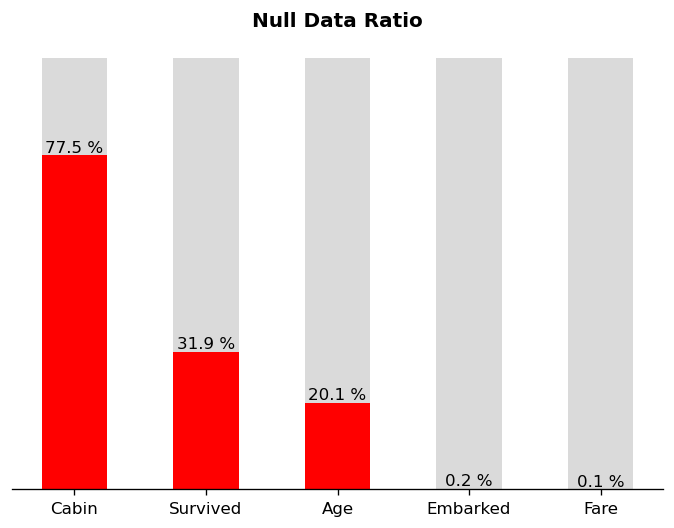

,count,percent
Cabin,1014.0,77.463713
Survived,418.0,31.932773
Age,263.0,20.091673
Embarked,2.0,0.152788
Fare,1.0,0.076394


In [10]:
missing_table = show_missing(all_data)
missing_table

# Remove Cabin since there are too much null value in the space

In [11]:
train_size = train_df.shape[0]
cabins = all_data.Cabin

all_data.drop(['Cabin'], axis=1, inplace=True)


In [12]:
pd.pivot_table(train_df, values='Age', index=['Pclass'],
              columns=['Survived'], aggfunc=[np.mean, np.std]).style.bar(subset=['mean']).background_gradient(subset=['std'])

## We looked at the mean and standard deviation of Age according to Pclass and Survived. The average of "age" varies depending on the group. I thought I could replace Age's missing values with the average of each group.

In [13]:
for c in [1, 2, 3]:
    for s in [0, 1]:
        all_data[(all_data.Pclass == c) & (all_data.Survived == s)]['Age'] = all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.fillna(all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.mean())
        
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

C:\Users\wangh\AppData\Local\Temp/ipykernel_15128/2942133840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[(all_data.Pclass == c) & (all_data.Survived == s)]['Age'] = all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.fillna(all_data[(all_data.Pclass == c) & (all_data.Survived == s)].Age.mean())


In [14]:
all_data.drop(['Survived'], axis=1).isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# 4. Analyze, identify patterns, and explore the data.

C:\Users\wangh\anaconda3\envs\tf-30x\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


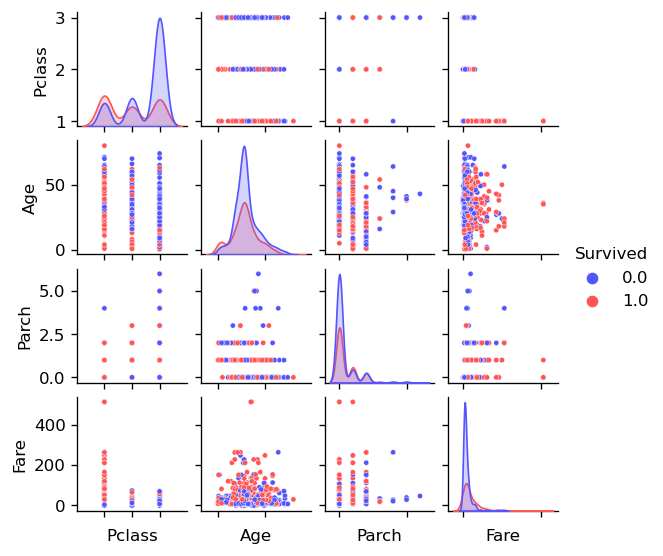

In [15]:
train = all_data.iloc[:train_size, :]
test = all_data.iloc[train_size:, :]

g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])
plt.show()

In [16]:
def drawcorr(data):
    mask = np.zeros_like(data.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(data.corr(),
                square=True, annot=True, fmt='.2f', center=0, linewidth=2,
                cbar=False, cmap=sns.diverging_palette(240, 10, as_cmap=True), mask=mask)
    plt.show()

C:\Users\wangh\AppData\Local\Temp/ipykernel_15128/2099231586.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype=np.bool)


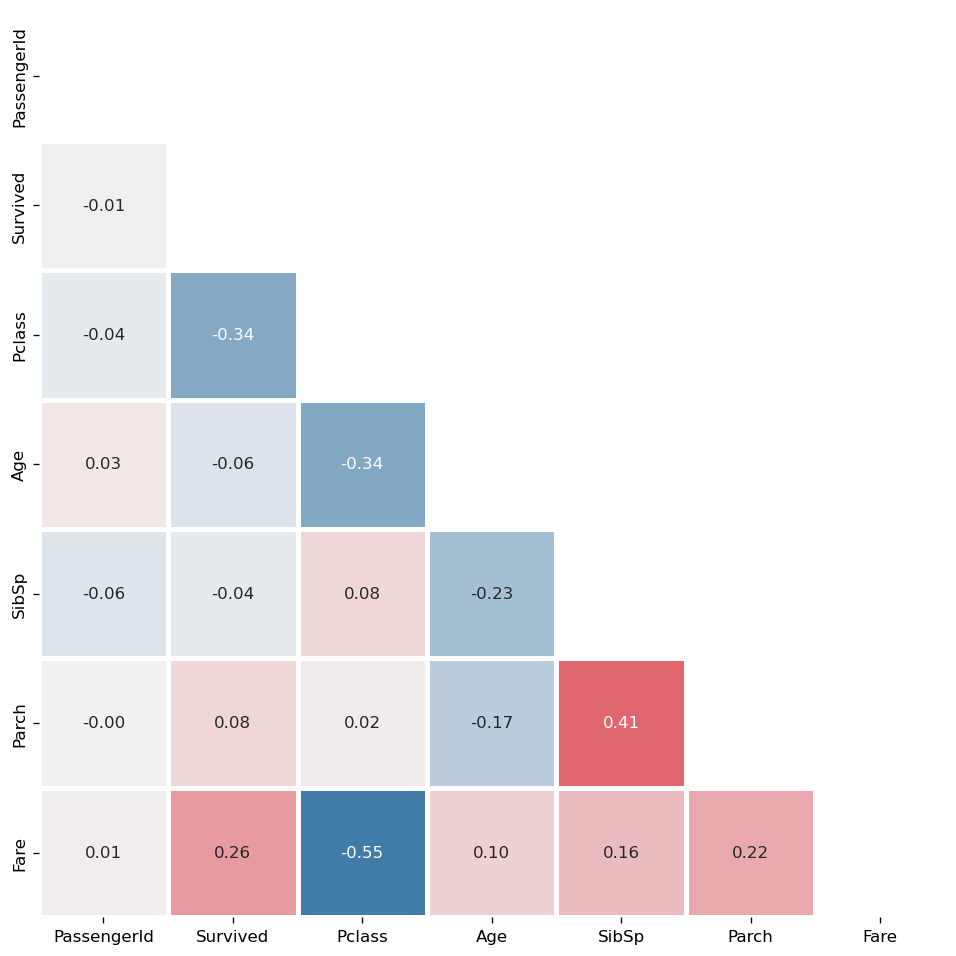

In [17]:
plt.subplots(figsize=(10, 10))
drawcorr(all_data.iloc[:train_size])

In [18]:
drop_features = [
    'PassengerId', 'Name', 'SibSp', 'Ticket'
]
all_data.drop(drop_features, axis=1, inplace=True)

In [19]:
from sklearn.preprocessing import LabelEncoder

nominals = [
    'Sex', 'Embarked'
]

le = LabelEncoder()

for f in nominals:
    all_data[f] = le.fit_transform(all_data[f])


# 5. Model, predict and solve the problem.

In [20]:
train = all_data.iloc[:train_size, :]
X_train, y_train = train.drop(['Survived'], axis=1), train.Survived.values
X_test = all_data.iloc[train_size:, :].drop(['Survived'], axis=1)

In [21]:
from sklearn.ensemble import RandomForestClassifier as rfc
model_rfc = rfc()
models = {
    'Random Forest': model_rfc,   
}


validation_scores = {}

In [22]:
X_train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked
0,3,1,22.0,0,7.2500,2
1,1,0,38.0,0,71.2833,0
2,3,0,26.0,0,7.9250,2
3,1,0,35.0,0,53.1000,2
4,3,1,35.0,0,8.0500,2


In [23]:
y_train.shape

(891,)

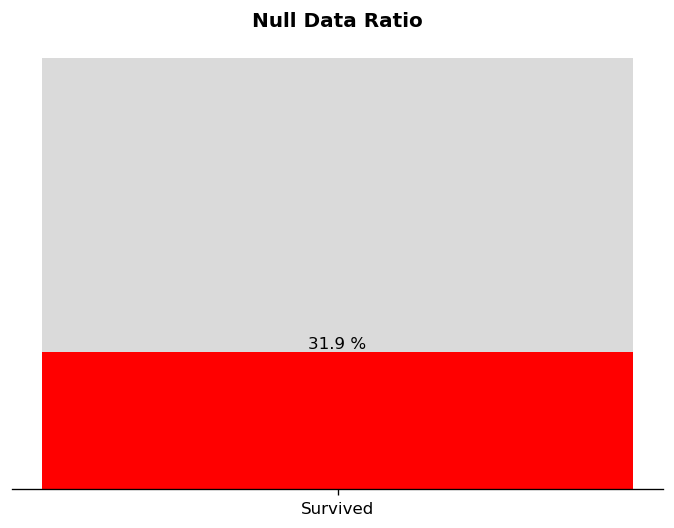

,count,percent
Survived,418.0,31.932773


In [24]:
missing_table = show_missing(all_data)
missing_table

In [25]:
from sklearn.model_selection import KFold, cross_val_score, learning_curve, GridSearchCV

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"{name}'s KFold Start")
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1, verbose=0).mean()
    print(f"{name}'s cross validation score: {score:.6f}\n")
    validation_scores[name] = score


Random Forest's KFold Start
Random Forest's cross validation score: 0.819333



In [26]:
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}



models_params = {
    'Random Forest': [model_rfc, rf_param_grid],
    
}
final_models = {
    
}

In [27]:
for name, [model, param] in models_params.items():
    print(f'{name} grid search start')
    search = GridSearchCV(model, param, cv=kf, n_jobs=-1, verbose=1,
                         scoring='accuracy').fit(X_train, y_train)
    final_models[name] = search.best_estimator_
    print(f'best score: {search.best_score_}\n')

Random Forest grid search start
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\wangh\anaconda3\envs\tf-30x\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.79237964 0.79238591 0.7957567  0.80250455 0.82268533 0.82267905
 0.83166154 0.82939552 0.8271546  0.8282782  0.83052539 0.83163643
 0.82155546 0.81817839 0.81817839 0.81930199 0.81818467 0.81593748
 0.80362187 0.80137468 0.80699893 0.80586278 0.83391501 0.83503233
 0.83388362 0.83277258 0.83164271 0.83276003 0.83501977 0.8350135
 0.8249388  0.8238152  0.82605612 0.82718599 0.82605612 0.82606239
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


best score: 0.8350323269097986



# 6. Visualize, report, and present the problem solving steps and final solution.

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

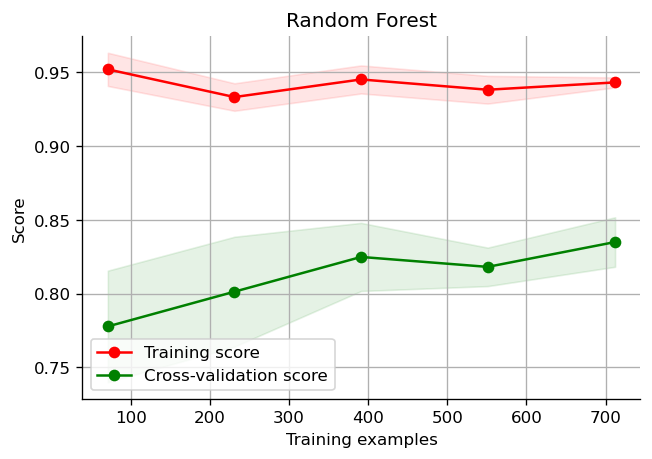

In [29]:
for name, model in final_models.items():
    plot_learning_curve(model, name, X_train, y_train, cv=kf)

# 7. Supply or submit the results.

In [31]:
# best score model.
test_id = test.PassengerId
test_Survived = pd.Series(final_models['Random Forest'].predict(X_test), name="Survived").astype('int')
results = pd.concat([test_id, test_Survived],axis=1)
results.to_csv("submission.csv",index=False)

In [32]:
# https://www.kaggle.com/arootda/the-basic-process-of-classification-for-beginners